In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from Naive_DAE import Naive_DAE,Dropout_DAE
import AE_Stats
from load_data_fn import load_data,load_data_no_filter,prep_ttbar

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib


# Loss Function Declarations

In [347]:
def AE_MSE(data,pred):
    return torch.mean(torch.sum((data-pred)**2,dim=1))

def AE_MAE(data,pred):
    return torch.mean(torch.sum(torch.abs(data-pred),dim=1))

def weighted_AE_MSE(data, pred):
    return torch.mean(torch.sum((data[:,0:48])**2,dim=1)*torch.sum((data-pred)**2,dim=1))

def dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))

def log_dif_weighted_AE_MSE(data, pred,alpha = 1):
    return torch.mean(torch.log((torch.sum(data[:,0:48]**2,dim=1)**0.5)*alpha+1)*(torch.sum((data-pred)**2,dim=1)))


def std_error(data,pred):
    return torch.mean(torch.sum(torch.abs(torch.subtract(data,pred)),dim=1))
def calcQ_Error(data,pred, mean,std):
    return torch.mean(torch.sum(torch.abs(pred-pred),dim=1))*std+mean
    
def new_loss(data,pred,epoch,cut = 50):
    #Reconstruction
    mse = AE_MSE(data,pred)
    if epoch < cut:
        return mse + std_error(data,pred) + calcQ_Error(data,pred,mean_dt_1,std_dt_1)
    else:
        #Energy Conservation
        sum_dt, sum_pred = torch.sum(data, dim=1), torch.sum(pred,dim=1)
        sum_error = torch.sum(torch.norm(sum_dt-sum_pred))
        

        return  mse +std_error(data,pred)+ calcQ_Error(data,pred,mean_dt_1,std_dt_1)+ sum_error*np.min([(epoch-cut)/cut,1])

In [330]:
torch.sum(torch.abs(model_1(AE_input[-size_test:,0:49])-AE_input[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1

tensor([54.6430, 54.0032, 54.6624,  ..., 71.6766, 66.3908, 69.6998],
       grad_fn=<AddBackward0>)

# Dataloading and sorting by wafer type

In [2]:
n = 80

arr = torch.load('TTBAR/ttbar_1_greater_0_sim')
if n > 0:
    for i in range(n):
        arr = torch.vstack([arr,torch.load(f'TTBAR/ttbar_{int(n+2)}_greater_0_sim')])



In [285]:
dt_1 = []
dt_2 = []
dt_3 = []

for a in arr:
    
    if a[-4].item() ==0.: 
        dt_1.append(a)
    elif a[-4].item() ==1.0: 
        dt_2.append(a)
    else:
        dt_3.append(a)
    
dt_1 = torch.vstack(dt_1).float()
dt_2 = torch.vstack(dt_2).float()   
dt_3 = torch.vstack(dt_3).float()   

In [257]:
mean_dt_1 = torch.mean(dt_1)
std_dt_1 = torch.std(dt_1)

Normalizing within each wafer type

In [258]:
# dt_1[:,0:48] = (dt_1[:,0:48] - torch.mean(dt_1[:,0:48]))/torch.std(dt_1[:,0:48])
# dt_2[:,0:48] = (dt_2[:,0:48] - torch.mean(dt_2[:,0:48]))/torch.std(dt_2[:,0:48])
# dt_3[:,0:48] = (dt_3[:,0:48] - torch.mean(dt_3[:,0:48]))/torch.std(dt_3[:,0:48])

In [241]:
wafer_sum = torch.sum(dt_1[:,0:48],dim=1)
AE_input = dt_1/torch.unsqueeze(wafer_sum,dim=1)



# Normalize by wafer_sum
Add sum of calcq to AE input, normalize by sum of calcq

In [242]:
dt_sum = torch.hstack([AE_input[:,0:48],torch.unsqueeze(wafer_sum,dim=1)])
AE_input = dt_sum


In [339]:

size_train =15000
size_test = 5000
train_loc = AE_input[0:size_train]
test_loc = AE_input[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=50,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=50,
    shuffle=False
)

train = AE_input[0:size_train,0:49]
test = AE_input[-size_test:,0:49]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=50,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=50,
    shuffle=False
)

In [348]:
num_epochs = 100
lr = 0.0045
loss =new_loss

In [338]:
model = nn.Sequential(nn.Linear(49,250),
                      nn.ReLU(),
                      nn.Linear(250,100),
                      nn.ReLU(),
                      nn.Linear(100,16),
                      nn.ReLU(),
                      nn.Linear(16,100),
                      nn.ReLU(),
                      nn.Linear(100,250),
                      nn.ReLU(),
                      nn.Linear(250,48),
                      nn.ReLU())

In [349]:
# fine-tune autoencoder
#batch 500
model_1 = model

# test = AE_input[-size_test:,0:49]

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_1.train()
        data = data_list[0]
        v_pred = model_1(data)
        
#         pred_sum = torch.unsqueeze(torch.sum(v_pred,dim=1),dim=1)
        
        batch_loss = loss(data[:,0:48], v_pred,epoch) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_test = test
    model_1.eval()
    test_pred = model_1(data_test)
    batch_test = loss(data_test[:,0:48], test_pred,epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_1.eval()

AE_Stats.gen_all_stats(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],AE_input[-size_test:])


Epoch 0, lr 0.0045
Epoch 0: Train 24.75402753194173, Test 24.749128341674805
Epoch 1, lr 0.0045
Epoch 1: Train 24.753209482828776, Test 24.74799346923828
Epoch 2, lr 0.0045
Epoch 2: Train 24.75313533782959, Test 24.74833869934082
Epoch 3, lr 0.0045
Epoch 3: Train 24.75295887629191, Test 24.747888565063477
Epoch 4, lr 0.0045
Epoch 4: Train 24.75280642191569, Test 24.747053146362305
Epoch 5, lr 0.0045
Epoch 5: Train 24.75273006439209, Test 24.747295379638672
Epoch 6, lr 0.0045
Epoch 6: Train 24.75294947306315, Test 24.748241424560547
Epoch 7, lr 0.0045
Epoch 7: Train 24.752913831075034, Test 24.74752426147461
Epoch 8, lr 0.0045
Epoch 8: Train 24.752935098012287, Test 24.746925354003906
Epoch 9, lr 0.0045
Epoch 9: Train 24.752829939524332, Test 24.747188568115234
Epoch 10, lr 0.0045
Epoch 10: Train 24.75288330713908, Test 24.747421264648438
Epoch 11, lr 0.00225
Epoch 11: Train 24.752897097269695, Test 24.74695587158203
Epoch 12, lr 0.00225
Epoch 12: Train 24.751159865061442, Test 24.74682

KeyboardInterrupt: 

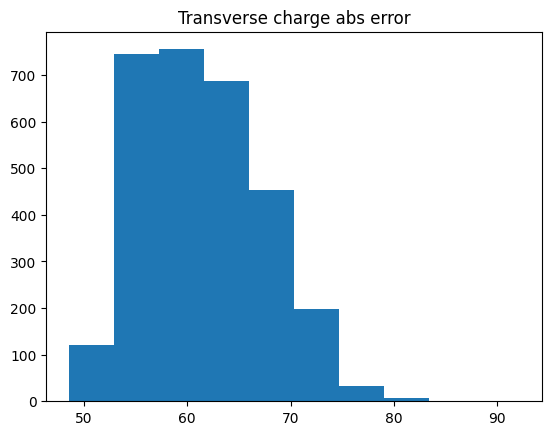

In [324]:
plt.title('Transverse charge abs error')
plt.hist((torch.sum(torch.abs(model_1(AE_input[-size_test:,0:49])-AE_input[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1).detach().numpy())
plt.show()

In [362]:
print(f'New Loss total: {new_loss(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48],epoch =10000)}')
print(f'MSE: {AE_MSE(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48]).item()}')
print(f'Average of total wafer calcq error / std: {std_error(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48])}')
print(f'Average Error in transverse charge: {calcQ_Error(model_1(AE_input[-size_test:,0:49]),AE_input[-size_test:,0:48], mean_dt_1,std_dt_1)}')

New Loss total: 53.113346099853516
MSE: 0.04561895877122879
Average of total wafer calcq error / std: 0.7746052145957947
Average Error in transverse charge: 23.924360275268555


# One of simon's suggestions
wafer_sum = sum(wafer_values)

AE_input = wafer_values / wafer_sum

rawAE = AE(AE_input)

AE_output = rawAE / sum(rawAE)

loss = loss(AE_input, AE_output)

-----------------------------------------
We normalize the input and ouput of the AE by its sum. Calculate loss between normalized wafer input and ouput

In [281]:
def norm_by_wafer_sum(dt):
    sum_dt = torch.unsqueeze(torch.sum(dt,dim=1),dim=1)
    return dt/sum_dt

In [286]:
normed_input = norm_by_wafer_sum(dt_1)

In [287]:
normed_input[0]

tensor([ 0.0046,  0.0000,  0.0138,  0.0173,  0.0046,  0.0035,  0.0576,  0.0081,
         0.0000,  0.0035,  0.0253,  0.0242,  0.0058,  0.0380,  0.0184,  0.0000,
         0.0207,  0.0046,  0.0000,  0.0138,  0.0000,  0.0000,  0.0092,  0.0000,
         0.0276,  0.0127,  0.0000,  0.0081,  0.1209,  0.0069,  0.0887,  0.0000,
         0.0219,  0.0242,  0.0173,  0.0242,  0.1715,  0.0000,  0.0046,  0.0058,
         0.0115,  0.0242,  0.0138,  0.0000,  0.0000,  0.0000,  0.0000,  0.0046,
         0.1128, -0.0012,  0.0104,  0.0058,  0.0035,  0.0010,  0.0000,  0.0012,
         0.0026,  0.0029])

In [318]:
mod_sum = nn.Sequential(nn.Linear(48,250),
                      nn.ReLU(),
                      nn.Linear(250,100),
                      nn.ReLU(),
                      nn.Linear(100,16),
                      nn.ReLU(),
                      nn.Linear(16,100),
                      nn.ReLU(),
                      nn.Linear(100,250),
                      nn.ReLU(),
                      nn.Linear(250,48),
                      nn.ReLU())

In [319]:
size_train =10000
size_test = 3000
train_loc = normed_input[0:size_train]
test_loc = normed_input[-size_test:]
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=50,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=50,
    shuffle=False
)

train = normed_input[0:size_train,0:48]
test = normed_input[-size_test:,0:48]
# train = torch.vstack([train,largest[0:1000]] )
train=train[torch.randperm(train.size()[0])]
test=test[torch.randperm(test.size()[0])]
train_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train)),
    batch_size=50,
    shuffle=False
)

test_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test)),
    batch_size=50,
    shuffle=False
)

Epoch 0, lr 0.0045
Epoch 0: Train 0.8577010461688042, Test 0.8440516591072083
Epoch 1, lr 0.0045
Epoch 1: Train 0.8398502826690674, Test 0.844105064868927
Epoch 2, lr 0.0045
Epoch 2: Train 0.8356710305809975, Test 0.8322348594665527
Epoch 3, lr 0.0045
Epoch 3: Train 0.8295446127653122, Test 0.8324507474899292
Epoch 4, lr 0.0045
Epoch 4: Train 0.8295013269782067, Test 0.8324810266494751
Epoch 5, lr 0.0045
Epoch 5: Train 0.8295342847704887, Test 0.8322681188583374
Epoch 6, lr 0.0045
Epoch 6: Train 0.8295695593953133, Test 0.8326473236083984
Epoch 7, lr 0.0045
Epoch 7: Train 0.8295371216535569, Test 0.8322610855102539
Epoch 8, lr 0.0045
Epoch 8: Train 0.8295311641693115, Test 0.8324240446090698
Epoch 9, lr 0.0045
Epoch 9: Train 0.8294938242435456, Test 0.832478940486908
Epoch 10, lr 0.0045
Epoch 10: Train 0.829527904689312, Test 0.8325130343437195
Epoch 11, lr 0.0045
Epoch 11: Train 0.829532350897789, Test 0.8324767351150513
Epoch 12, lr 0.0045
Epoch 12: Train 0.829517755806446, Test 0.83

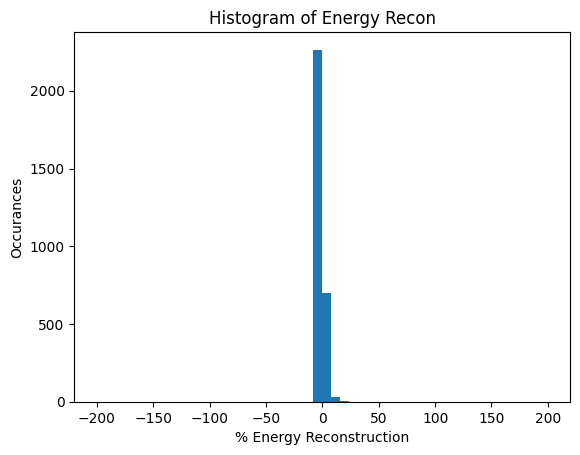

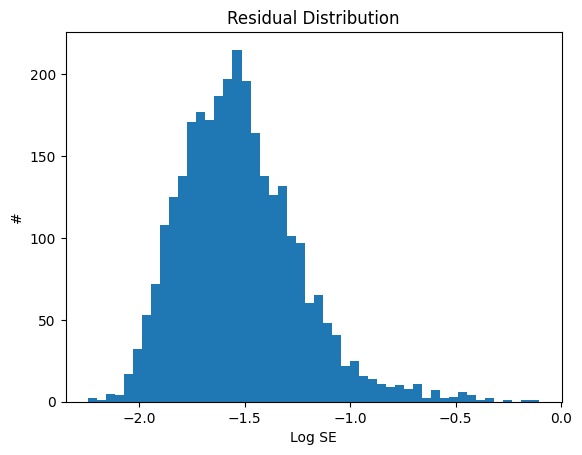

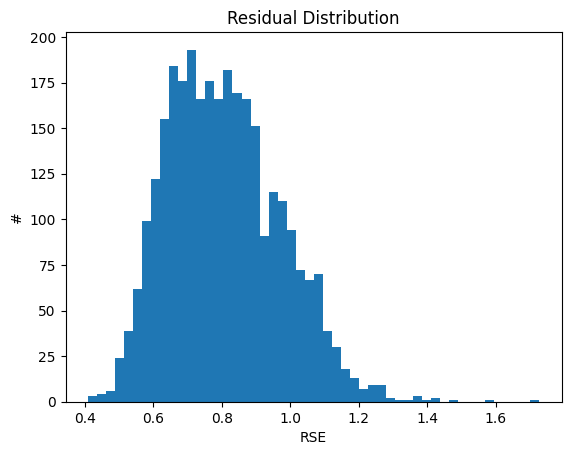

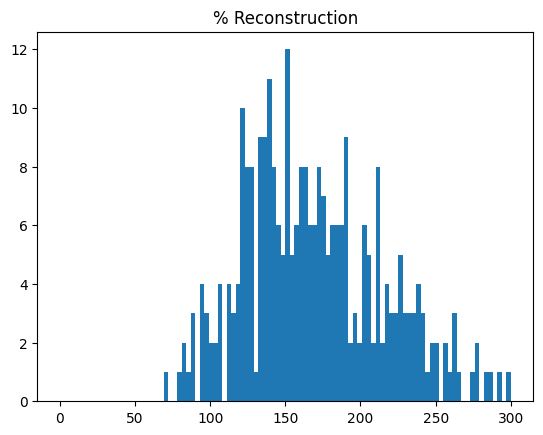

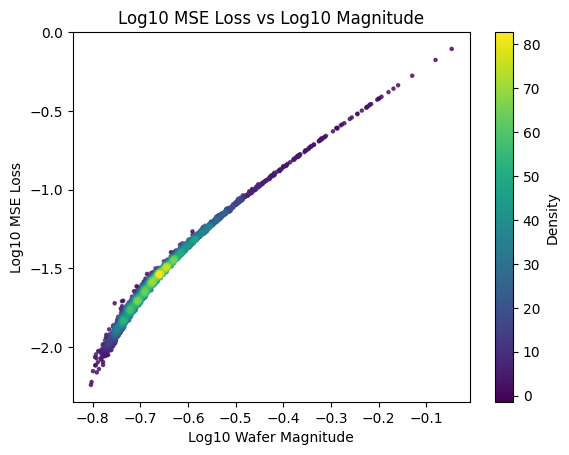

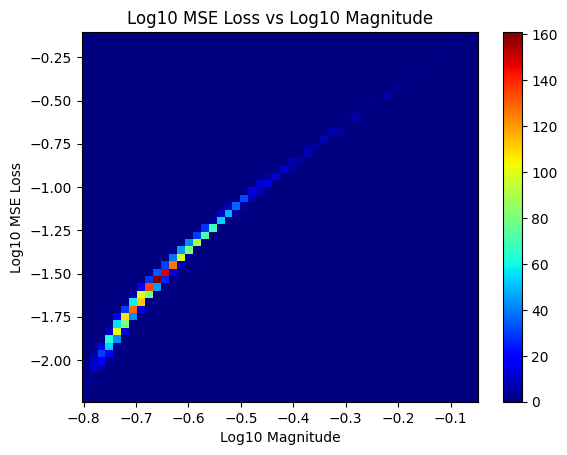

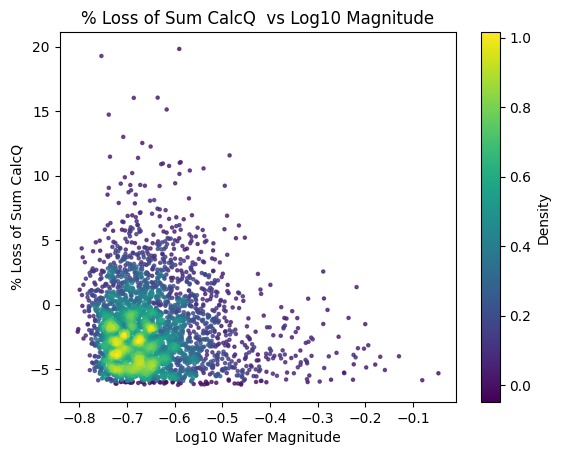

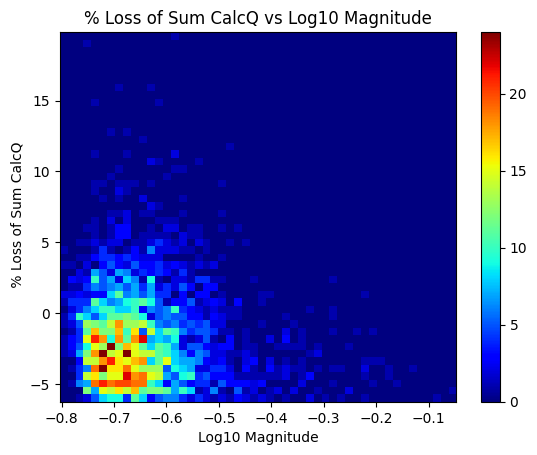

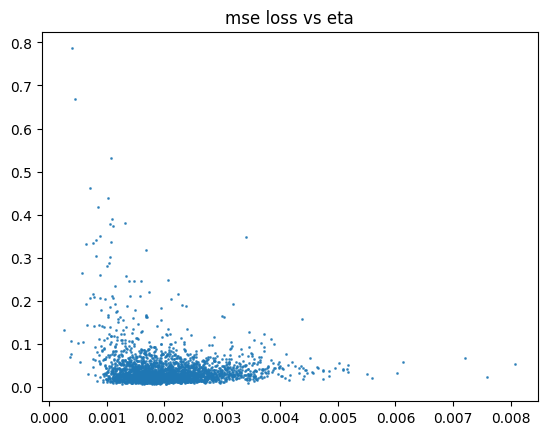

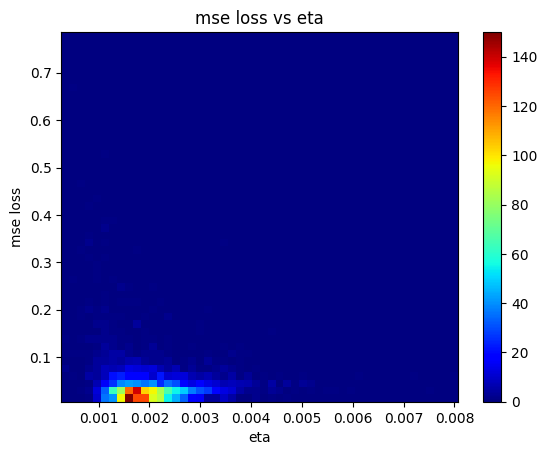

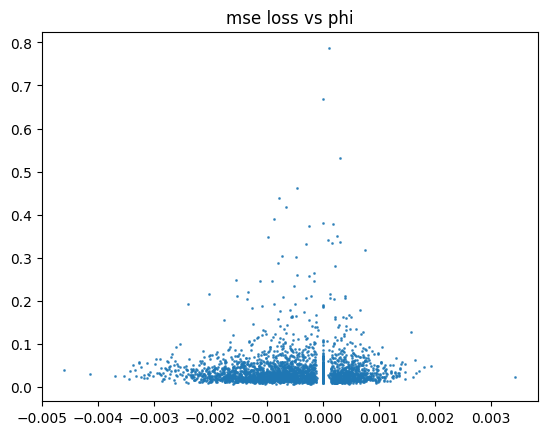

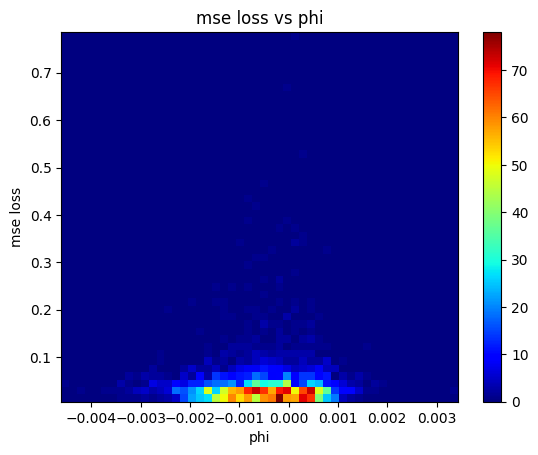

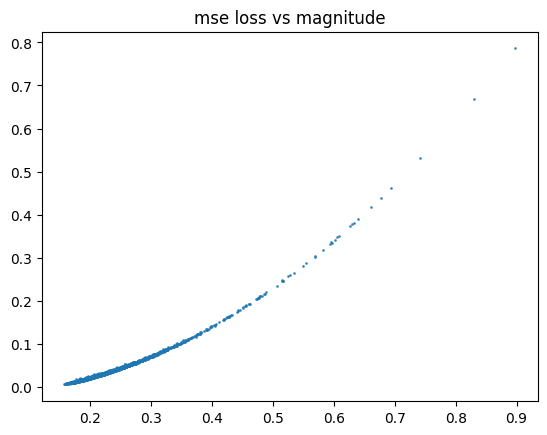

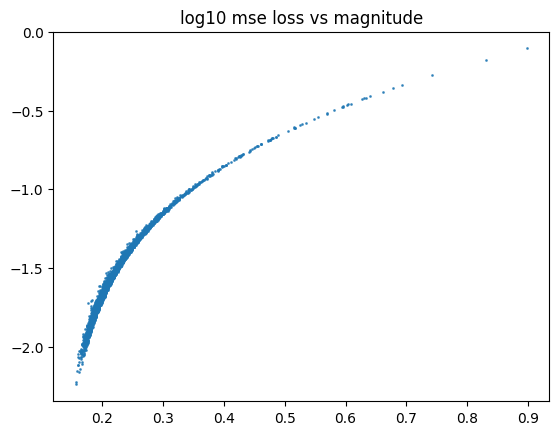

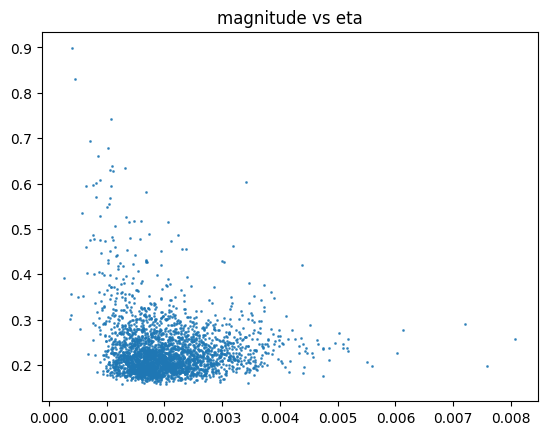

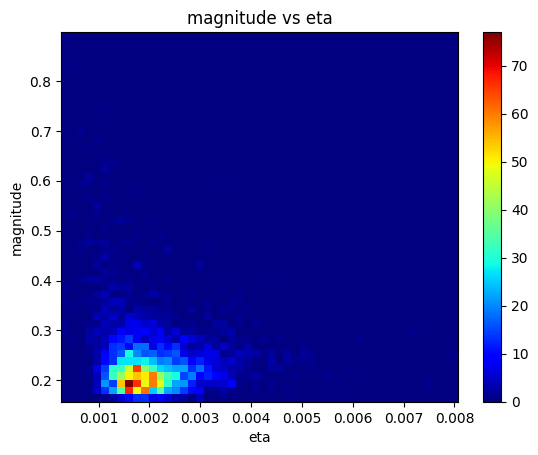

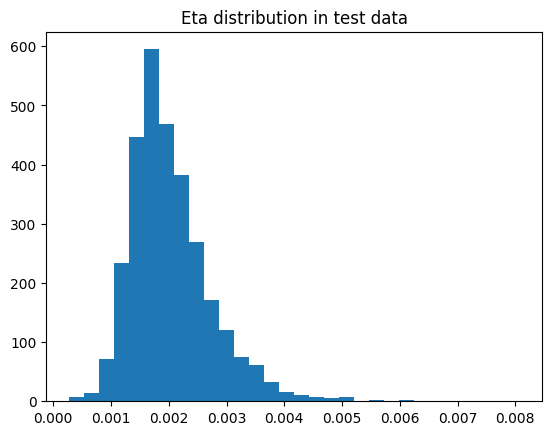

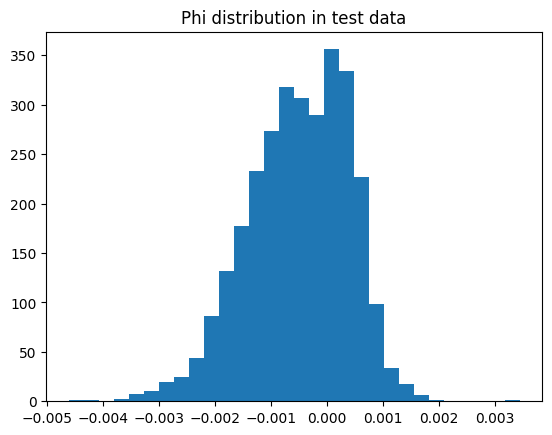

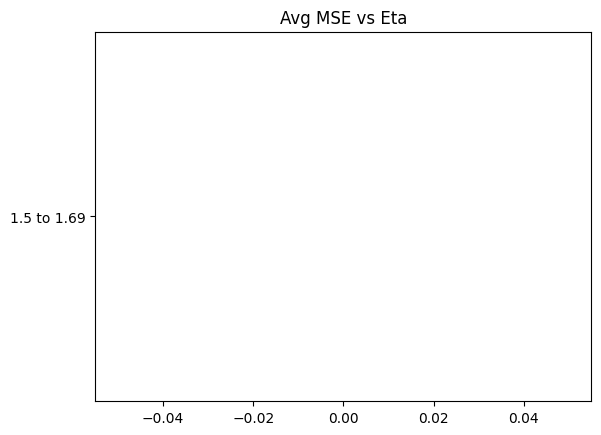

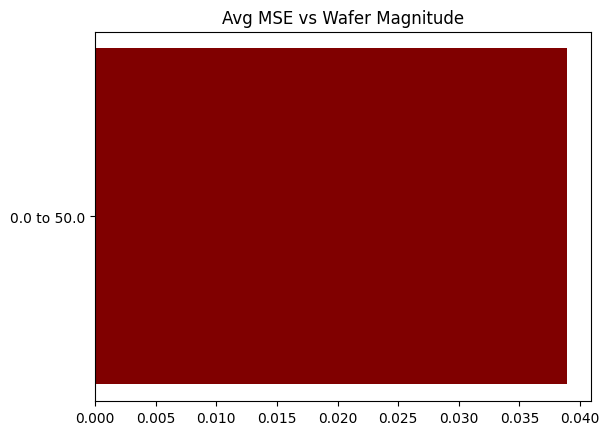

tensor([[ 1.4214e-03, -1.2684e-03,  1.7960e-01,  1.2855e-02,  5.8919e-01],
        [ 1.7429e-03, -1.5553e-03,  1.7430e-01,  1.1357e-02,  5.9255e-01],
        [ 2.0082e-03, -1.7920e-03,  2.0003e-01,  2.0760e-02,  6.6471e-01],
        ...,
        [ 3.2575e-03, -9.2792e-04,  2.5168e-01,  4.8005e-02,  1.0108e+00],
        [ 1.8879e-03, -5.3779e-04,  2.2157e-01,  3.1719e-02,  9.0602e-01],
        [ 3.6803e-03, -1.0484e-03,  2.1471e-01,  3.1616e-02,  9.7537e-01]],
       grad_fn=<CatBackward0>)

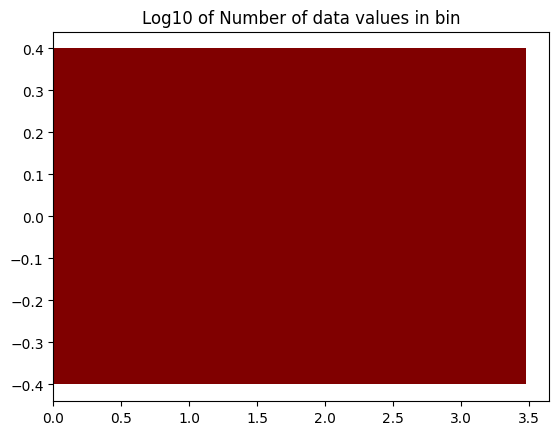

In [321]:
# fine-tune autoencoder
#batch 500
model_norm = mod_sum

test = normed_input[-size_test:,0:48]

optimizer = optim.Adam(model_norm.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.5)

all_test_losses = []
all_train_losses = []
# train
running_loss = float("inf")
for epoch in range(num_epochs):
    
    losses = []
    
    for i, data_list in enumerate(train_d1_flat):
        model_norm.train()
        data = data_list[0]
        v_pred = model_norm(data)
        
#         pred_sum = torch.unsqueeze(torch.sum(v_pred,dim=1),dim=1)
        
        batch_loss = loss(data[:,0:48], norm_by_wafer_sum(v_pred),epoch) # difference between actual and reconstructed   
        
        
        all_train_losses.append(batch_loss.item())
        losses.append(batch_loss.item())
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_test = test
    model_norm.eval()
    test_pred = model_norm(data_test)
    batch_test = loss(data_test[:,0:48], norm_by_wafer_sum(test_pred),epoch)
    running_loss = np.mean(losses)
    running_test_loss = batch_test.item()
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_test_loss}")
model_norm.eval()

AE_Stats.gen_all_stats(model_norm(normed_input[-size_test:,0:48]),normed_input[-size_test:,0:48],normed_input[-size_test:])


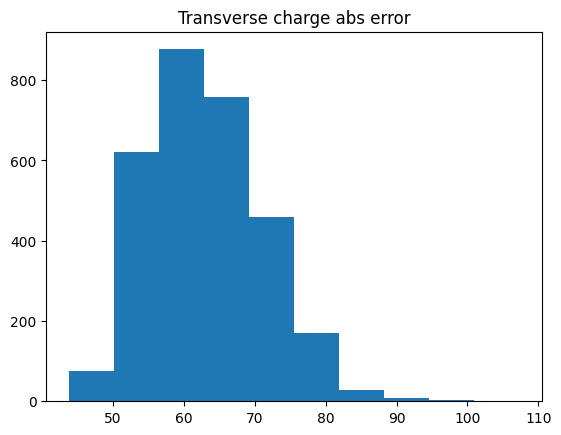

In [323]:
plt.title('Transverse charge abs error')
plt.hist((torch.sum(torch.abs(model_norm(normed_input[-size_test:,0:48])-normed_input[-size_test:,0:48]),dim=1)*std_dt_1+mean_dt_1).detach().numpy())
plt.show()